# If using Google CoLab Connect to Drive

In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [2]:
import os
os.chdir("gdrive/MyDrive/Lentil Project/")

In [3]:
!pwd

/content/gdrive/MyDrive/Lentil Project


# If not using CoLab Start Here

In [4]:
import torch
import torchvision

import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F


from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split, ConcatDataset
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler

import torch.optim as optim

import pandas as pd

from torchvision.datasets import CIFAR10

from skimage import io

import copy
%matplotlib inline

In [ ]:
torch.cuda.empty_cache()

Data Loader

In [ ]:
class LentilDataset(Dataset): 
    def __init__(self, paths, transformer): 
        super(LentilDataset, self).__init__()
        self.image_paths = paths
        self.transformer = transformer
        
    def __len__(self): 
        return len(self.image_paths)
    
    def __getitem__(self, item): 
        path = self.image_paths[item]
        image = io.imread(path)
        
        image = self.transformer(image)
            
        return item, image

In [ ]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize(size=(256, 256)),
    torchvision.transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

In [ ]:
df = pd.read_csv('../metadata/real_features.csv')
paths = df.Image.tolist()
# may need to change paths depending where images are saved
for i in range(len(paths)):
    paths[i] = "../" + paths[i].split("/")[-2]+"/"+paths[i].split("/")[-1]

In [ ]:
train_paths, valid_paths = np.split(paths, [int(.8*len(df))])

In [ ]:
train_dataset = LentilDataset(train_paths, transform)
valid_dataset = LentilDataset(valid_paths, transform)
train_dataset.image_paths.shape

(1272,)

In [ ]:
# Define dataloaders. 
BATCH_SIZE = 16

train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=0
)
valid_loader = DataLoader(
    valid_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    num_workers=0
)

In [ ]:
for data in train_loader:
    items, image = data
    print(image.shape)

torch.Size([16, 3, 256, 256])
torch.Size([16, 3, 256, 256])
torch.Size([16, 3, 256, 256])
torch.Size([16, 3, 256, 256])
torch.Size([16, 3, 256, 256])
torch.Size([16, 3, 256, 256])
torch.Size([16, 3, 256, 256])
torch.Size([16, 3, 256, 256])
torch.Size([16, 3, 256, 256])
torch.Size([16, 3, 256, 256])
torch.Size([16, 3, 256, 256])
torch.Size([16, 3, 256, 256])
torch.Size([16, 3, 256, 256])
torch.Size([16, 3, 256, 256])
torch.Size([16, 3, 256, 256])
torch.Size([16, 3, 256, 256])
torch.Size([16, 3, 256, 256])
torch.Size([16, 3, 256, 256])
torch.Size([16, 3, 256, 256])
torch.Size([16, 3, 256, 256])
torch.Size([16, 3, 256, 256])
torch.Size([16, 3, 256, 256])
torch.Size([16, 3, 256, 256])
torch.Size([16, 3, 256, 256])
torch.Size([16, 3, 256, 256])
torch.Size([16, 3, 256, 256])
torch.Size([16, 3, 256, 256])
torch.Size([16, 3, 256, 256])
torch.Size([16, 3, 256, 256])
torch.Size([16, 3, 256, 256])
torch.Size([16, 3, 256, 256])
torch.Size([16, 3, 256, 256])
torch.Size([16, 3, 256, 256])
torch.Size

In [1]:
import torchsummary
model = torchvision.cuda.models.vgg19()
torchsummary.summary(model, (3, 256, 256))

ModuleNotFoundError: No module named 'torchsummary'

**Model Definition**

In [ ]:
# Encoder Class
class Encoder(nn.Module):
    def __init__(self, pretrained_model):
        super(Encoder, self).__init__()
        # Define main module.
        self.encoder_layers = nn.ModuleList(
            *pretrained_model[:-2] # Removing Fully connected module, and the AdaptiveAvgPool2d
        )

        for i in range(len(self.encoder_layers)): 
            if isinstance(self.encoder_layers[i], nn.MaxPool2d):
              self.encoder_layers[i] = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, 
                                                    ceil_mode=False, return_indices=True)    
        # Define linear module. 
        self.linear_encoder_module = nn.Sequential(
            nn.Linear(in_features=512 * 8 * 8, out_features=1024, bias=True),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(1024, 128, bias=True)
        )

    def forward(self, x):
      # Apply main module.
      maxpool_indices = []
      for layer in self.encoder_layers:
          if isinstance(layer, nn.MaxPool2d):
              x, indices = layer(x)
              maxpool_indices.append(indices)
          else:
              x = layer(x)
      # Apply linear module.
      x = x.view(-1, self.linear_encoder_module[0].in_features)
      x = self.linear_encoder_module(x)
      return x, maxpool_indices

In [ ]:
# Decoder Class.
class Decoder(nn.Module):
    def __init__(self, pretrained_model):
        super(Decoder, self).__init__()
        # Define Decoder linera module.
        self.linear_decoder_module = nn.Sequential(
            nn.Linear(128, 1024),
            nn.Dropout(p=0.5, inplace=False),
            nn.ReLU(),
            nn.Linear(1024, 512 * 8 * 8)
        )
        # Define upsampling reference layer. 
        reference_model_layers = nn.ModuleList(
            *pretrained_model[:-2]
        )
        self.decoder = nn.ModuleList() # Define the decoder empty model. 
        for ref_layer in reference_model_layers[::-1]: # iterate over Reversed reference model. 
            layer = None 
            if isinstance(ref_layer, nn.MaxPool2d):
                layer = nn.MaxUnpool2d(kernel_size=2, stride=2, padding=0)
            if isinstance(ref_layer, nn.Conv2d):
                layer = nn.Sequential(
                    nn.Conv2d(
                          in_channels=ref_layer.out_channels, out_channels=ref_layer.in_channels, 
                          kernel_size=3, stride=1, padding=1
                    ), 
                    nn.BatchNorm2d(num_features=ref_layer.in_channels), # If you want to exclude BatchNorm Layer you can comment this line. 
                    nn.ReLU() # If you want to exclude ReLU you can comment this line.
                )
            if layer is not None: 
                self.decoder.append(layer)
        self.decoder.append(nn.Sigmoid())

    def forward(self, x, indices_list):
        # Applying linear module. 
        x = self.linear_decoder_module(x)
        x = x.view(-1, 512, 8, 8)
        # Applying main module.
        indices_list = indices_list[::-1] # Reverce the indices_list.
        i = 0
        for layer in self.decoder:
          if isinstance(layer, nn.MaxUnpool2d):
            x = layer(x, indices=indices_list[i])
            i += 1
          else:
              x = layer(x)
        return x

In [ ]:
from torch.nn.modules.activation import ReLU
class CNN_Model(nn.Module):
    def __init__(self, reference_model):
        super().__init__()
        self.encoder = Encoder(copy.deepcopy(reference_model))
        self.decoder = Decoder(copy.deepcopy(reference_model))

    def forward(self, x):
        encoded, maxpool_indices = self.encoder(x)
        decoded = self.decoder(encoded, maxpool_indices)
        return decoded
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Set device to ', device)
# can change reference model to another vgg network
model = CNN_Model(
    reference_model=list(torchvision.models.vgg16(pretrained=True).children())
)
model = model.to(device)

Set device to  cuda


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [ ]:
 #print(model)

In [ ]:
# can use as custom loss function
class Loss(nn.Module): 
    def __init__(self): 
        super().__init__()
        self.loss1 = nn.MSELoss()
        self.loss2 = nn.L1Loss()
    
    def __call__(self, predictions, ground_truth): 
        return (self.loss1(predictions, ground_truth) + 
               self.loss2(predictions, ground_truth)
               )
    
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)

In [ ]:
MAXEPOCH = 50

train_loss_tracking = []
vlaid_loss_tracking = []

print("Start")
for epoch in range(MAXEPOCH):
    print("Epoch:", epoch)
    # Change the development mode to the training mode. 
    model.train()
    running_loss = 0.0
    
    running_steps = 0
    for i, data in enumerate(train_loader, 0):
        _, images = data
        images=images.to(device)

        optimizer.zero_grad()

        outputs = model(images)

        loss = criterion(outputs, images.clone())
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        running_steps += 1
    train_loss = running_loss / running_steps
    train_loss_tracking.append(train_loss)

    print(f'Train --> Epoch: {epoch}, Loss: {train_loss}.')

    # Evaluate the model for this epoch. 
    # Change the development mode to the evaluating mode. 
    model.eval()
    with torch.no_grad():
        running_loss = 0.0

        running_steps = 0
        for i, data in enumerate(valid_loader, 0):
            _, features = data
            features=features.to(device)

            outputs = model(features)
            loss = criterion(outputs, features)

            running_loss += loss.cpu().item()
  
            running_steps += 1
        valid_loss = running_loss / running_steps
        vlaid_loss_tracking.append(valid_loss)

        print(f'Valid --> Epoch: {epoch}, Loss: {valid_loss}.')
        print('-' * 50)
        
print('Finished.')

Start
Epoch: 0
Train --> Epoch: 0, Loss: 1.3953763410449027.
Valid --> Epoch: 0, Loss: 1.3194078862667085.
--------------------------------------------------
Epoch: 1
Train --> Epoch: 1, Loss: 1.3707336828112602.
Valid --> Epoch: 1, Loss: 1.287602722644806.
--------------------------------------------------
Epoch: 2
Train --> Epoch: 2, Loss: 1.3634044036269188.
Valid --> Epoch: 2, Loss: 1.2828770250082016.
--------------------------------------------------
Epoch: 3
Train --> Epoch: 3, Loss: 1.3594983771443367.
Valid --> Epoch: 3, Loss: 1.2807614535093308.
--------------------------------------------------
Epoch: 4
Train --> Epoch: 4, Loss: 1.3593458652496337.
Valid --> Epoch: 4, Loss: 1.2794521808624268.
--------------------------------------------------
Epoch: 5
Train --> Epoch: 5, Loss: 1.3592777013778687.
Valid --> Epoch: 5, Loss: 1.2796163469552995.
--------------------------------------------------
Epoch: 6
Train --> Epoch: 6, Loss: 1.3574745208024979.
Valid --> Epoch: 6, Loss: 1.

**Visualize the Loss Over Different Epochs**

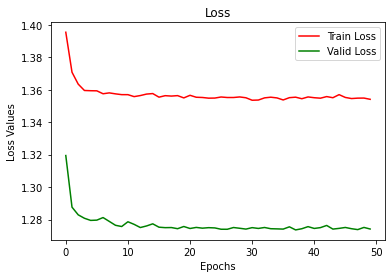

In [ ]:
plt.plot(range(len(train_loss_tracking)), train_loss_tracking, 'r-', label='Train Loss')
plt.plot(range(len(vlaid_loss_tracking)), vlaid_loss_tracking, 'g-', label='Valid Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss Values')
plt.legend()
plt.show()

In [ ]:
# change path to where you want to save model
PATH = '../TransferCNN/VGG/CNN6.pth'
torch.save(model.state_dict(), PATH)

In [ ]:
# Load the best saved model. 
checkpoint = torch.load('../TransferCNN/VGG/CNN^.pth')
# Define the base model.
model = CNN_Model(
    reference_model=list(torchvision.models.vgg16(pretrained=True).children())
)
# Load the weights. 
model.load_state_dict(checkpoint)
model = model.to(device)
model = model.eval()

In [ ]:
# encode the images

df = pd.read_csv('../metadata/real_features.csv')
paths = df.Image.tolist()
for i in range(len(paths)):
    paths[i] = "../" + paths[i].split("/")[-2]+"/"+paths[i].split("/")[-1]

image_dataset = LentilDataset(paths, transform)


image_loader = DataLoader(
    image_dataset, 
    batch_size=64, 
    shuffle=False,
    num_workers=0
)

output_images = []
output_items = []
with torch.no_grad():
    for i, data in enumerate(image_loader):
        print(i)
        items, images = data
        images = images.to(device)
        output, indices = model.encoder(images)
        output_images.extend(output.cpu().numpy().tolist())
        output_items.extend(items.numpy().tolist())

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


In [ ]:
# save encoded features

output_paths = pd.DataFrame({"Image":[paths[i] for i in output_items]})
output_features = pd.DataFrame(output_images)

output_features = pd.concat([output_paths, output_features], axis=1)
output_features.head()


,Image,0,1,2,3,4,5,6,7,8,...,118,119,120,121,122,123,124,125,126,127
0,../real_regions/0000_16401081_1.png,-0.200978,0.213196,-1.369448,-0.220220,-0.162302,0.475558,0.619602,-0.242718,-0.008542,...,0.351919,0.494627,-0.196244,-0.178202,1.067329,-0.401638,-0.878526,-0.088733,-0.506404,0.643858
1,../real_regions/0001_16401081_10.png,-0.004492,0.113322,-0.736791,-0.093579,-0.154324,0.320086,0.396997,-0.241123,0.100578,...,0.110217,0.448000,-0.246624,0.093985,0.906550,-0.351883,-0.510070,-0.159958,-0.446981,0.320377
2,../real_regions/0002_16401081_11.png,-0.034915,0.137256,-0.784063,-0.114133,-0.213609,0.308362,0.424661,-0.147258,0.015742,...,0.040688,0.445498,-0.216090,0.090196,0.756271,-0.329647,-0.566823,-0.161953,-0.394717,0.189014
3,../real_regions/0003_16401081_12.png,-0.000117,0.110674,-0.698490,-0.110241,-0.175622,0.314529,0.387562,-0.217386,0.080806,...,0.085048,0.469593,-0.247111,0.123305,0.861673,-0.349628,-0.496976,-0.175754,-0.437957,0.261786
4,../real_regions/0004_16401081_14.png,-3.850628,-0.032314,-6.763506,-1.676245,1.598400,3.568512,2.967791,2.220088,-1.495821,...,0.735997,1.182367,0.133087,-4.864451,1.151105,-0.718605,-4.125764,1.368015,1.266999,2.087436


In [ ]:
output_features.to_csv("../metadata/vgg_encoded_features.csv", index=False)

**Check Decoded Images**

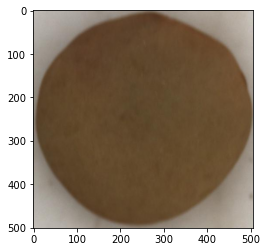

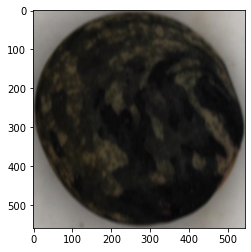

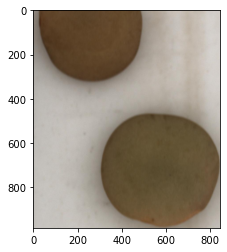

In [ ]:
# show original images
image_paths = ['../real_regions/0003_16401081_12.png', '../real_regions/1003_16401081_41.png', '../real_regions/0011_16401081_22.png']

for path in image_paths:
  img = io.imread(path)
  plt.imshow(img)
  plt.show()

In [ ]:
#load the model

# Load the best saved model. 
checkpoint = torch.load('../TransferCNN/VGG/CNN10.pth', map_location=device)
# Define the base model.
model = CNN_Model(
    reference_model=list(torchvision.models.vgg19(pretrained=True).children())
)
# Load the weights. 
model.load_state_dict(checkpoint)
model = model.to(device)
model = model.eval()

In [ ]:
#encode and decode the images


image_test_dataset = LentilDataset(image_paths, transform)


image_test_loader = DataLoader(
    image_test_dataset, 
    batch_size=1, 
    shuffle=False,
    num_workers=0
)

output_images = []
output_index = []
with torch.no_grad():
    for i, data in enumerate(image_test_loader):
        index, images = data
        images = images.to(device)
        output = model(images)
        output_images.extend(output.cpu().numpy())
        output_index.extend(index.numpy().tolist())

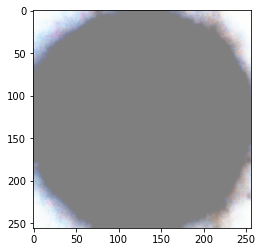

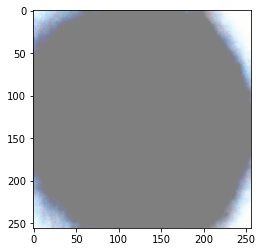

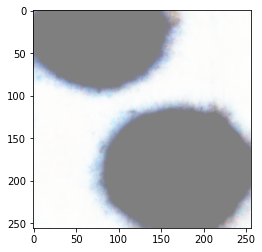

In [ ]:
# show decoded images
for img in output_images:
  img = img.swapaxes(0,1)
  img = img.swapaxes(1,2)
  plt.imshow(img)
  plt.show()

**Encode new lentil images**

In [ ]:
#load the model

# Load the best saved model. 
checkpoint = torch.load('TransferCNN/VGG/CNN6.pth', map_location=device)
# Define the base model.
model = CNN_Model(
    reference_model=list(torchvision.models.vgg19(pretrained=True).children())
)
# Load the weights. 
model.load_state_dict(checkpoint)
model = model.to(device)
model = model.eval()

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

In [ ]:
# encode the images

df = pd.read_csv('metadata/new_lentil_paths.csv')
paths = df.Image.tolist()

image_dataset = LentilDataset(paths, transform)


image_loader = DataLoader(
    image_dataset, 
    batch_size=64, 
    shuffle=False,
    num_workers=0
)

output_images = []
output_items = []
with torch.no_grad():
    for i, data in enumerate(image_loader):
        print(i)
        items, images = data
        images = images.to(device)
        output, indices = model.encoder(images)
        output_images.extend(output.cpu().numpy().tolist())
        output_items.extend(items.numpy().tolist())

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


In [ ]:
# save the encoded features
output_paths = pd.DataFrame({"Image":[paths[i] for i in output_items]})
output_features = pd.DataFrame(output_images)

output_features = pd.concat([output_paths, output_features], axis=1)
output_features.head()


,Image,0,1,2,3,4,5,6,7,8,...,118,119,120,121,122,123,124,125,126,127
0,New_Lentils/brown-marbled-7059 (segmented)/164...,3.472744,-7.791566,-11.115875,-28.577242,0.416464,3.195112,-18.978952,9.062703,8.709677,...,0.715232,0.373784,-1.543487,-19.384401,9.337774,4.547543,3.055873,0.819611,-2.488159,-16.804657
1,New_Lentils/brown-marbled-7059 (segmented)/164...,4.261943,-8.690232,-12.435905,-31.215820,0.302173,3.897196,-20.949816,9.975708,9.654572,...,1.050864,0.369083,-2.112067,-21.117386,10.937609,3.782949,3.984198,0.108885,-3.421465,-18.467602
2,New_Lentils/brown-marbled-7059 (segmented)/164...,3.277071,-8.328452,-12.179215,-29.450203,0.279695,3.429807,-19.627571,9.451573,9.368268,...,0.423134,0.352748,-2.137646,-19.859459,9.923081,4.942915,3.586838,0.727810,-3.213026,-17.622442
3,New_Lentils/brown-marbled-7059 (segmented)/164...,3.831583,-9.199608,-12.915775,-33.099720,0.173131,4.311076,-22.165121,10.555343,9.751234,...,0.831147,0.317629,-2.794471,-22.834976,10.731540,5.125924,4.280877,0.738847,-3.114667,-19.237587
4,New_Lentils/brown-marbled-7059 (segmented)/164...,3.549095,-7.697216,-11.077764,-27.136477,0.225350,3.355776,-18.175486,8.709937,8.654549,...,0.778002,0.390469,-1.845145,-18.279079,9.577237,3.581088,3.581614,0.128818,-3.273410,-16.112465


In [ ]:
output_features.to_csv("metadata/newlentils_vgg19_encoded_features.csv", index=False)